# Importing packages and establishing a connection with Reddit API

In [67]:
import praw
import config_reddit
import json
from os import path
import os
import numpy as np


reddit = praw.Reddit(user_agent=f"Exploration script by /u/{config_reddit.user_name}",
                     client_id=config_reddit.app_id,
                     client_secret=config_reddit.app_secret)

reddit.read_only

True

# Collecting Data From Reddit

In [27]:
# I am going to analyze the subreddit r/worldcup/ - https://www.reddit.com/r/worldcup/
# since the is the biggest football event in the world and is happening this year.
query_subreddit = 'worldcup'

# Number of posts and Comments
nposts = 50
ncomments = 15

# Collecting posts_ids
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)

len(post_ids)

50

In [28]:
# Showing an example of a ramdon post from the data collected.
post_details = reddit.submission(id = post_ids[0])

print(f"Title: {post_details.title} \n")
print(f"Selftext: {post_details.selftext}")

Title: TRAVEL MEGATHREAD 

Selftext: All things travel related. Any posts/questions/comments outside of this thread regarding Tickets, Accommodations, etc. will be removed!


In [29]:
# Collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [30]:
# Collecting information for each post
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [31]:
# save collected data to json file
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent=2))

# Analysis of World Cup posts on Reddit

In [32]:
#Importing packages
import html
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [34]:
# Import json file with data collected
fjson = 'raw_post_comment_data.json'

# read json file with collected posts and comments
with open(fjson) as file:
    data = json.load(file)
    
print(f"""The file has {len(data)} posts
One example from the data is the post below: \n""")

data[0]

The file has 50 posts
One example from the data is the post below: 



{'id': 'tmupei',
 'title': 'TRAVEL MEGATHREAD',
 'text': 'All things travel related. Any posts/questions/comments outside of this thread regarding Tickets, Accommodations, etc. will be removed!',
 'comments_lev1': ["This was the reply I received when I wrote to enquire about the hotel situation for the upcoming world cup. Looks like the chances of getting a decent hotel is almost slim to none.\n\nHopefully there's adequate accommodation in the fan villages. :(\n\n&#x200B;\n\nThank you for your enquiry on hotel availability. \r  \n\r  \nAll hotel inventory has been reserved by key event groups; therefore, we unfortunately don’t have any inventory available for other client groups at the moment. A limited number of hotels may become available after July but we would recommend that you arrange your accommodation now because we cannot guarantee hotel inventory to meet your requirements will become available at a later date.\r  \n\r  \nThe host country has contracted apartments, villas and 

In [35]:
# Creating a DataFrame with the titles of the posts
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,TRAVEL MEGATHREAD
1,I am drawing every single sticker from the new...
2,"The results are in, group H is eliminated! Thu..."
3,What's your shout for the most underrated Worl...
4,Idea to meet people going to world cup?
5,2006 World Cup: Ukraine defeats Saudi Arabia 4...
6,How likely is it Chile will successfully appea...
7,Chile decided to appeal the Byron Castillo ruling
8,What are some of your favorite World Cup Podca...
9,Missing the World Cup


In [36]:
# Adding columns to the title DataFrame, like the comments and subcomments
df_posts['post_id'] = [p['id'] for p in data] # Adding the column post_id to the DataFrame through a loop
df_posts['text'] = [p['text'] for p in data] # Adding the column text to the the DataFrame through a loop
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data] # Adding the column comment to the DataFrame
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data] # Adding the column subcomment to the DataFrame
df_posts


,title,post_id,text,comments_lev1,comments_lev2
0,TRAVEL MEGATHREAD,tmupei,All things travel related. Any posts/questions...,This was the reply I received when I wrote to ...,"I got this reply too, like if they told us thi..."
1,I am drawing every single sticker from the new...,wbaxia,,Great idea! How many are there and how many ha...,I have done just 60 yet and there is gonna be ...
2,"The results are in, group H is eliminated! Thu...",waxxm3,,What do you know about bias?\n\n/s Wales and I...,That's what makes the group boring. Everyone k...
3,What's your shout for the most underrated Worl...,wb1k0h,I found this [one football article](https://on...,Tim Cahill's goal against the Netherlands in 2...,Tim was great for Everton and Aussies. Slightl...
4,Idea to meet people going to world cup?,wb81gz,Hey guys I’m going to the World Cup and though...,Hi,
5,2006 World Cup: Ukraine defeats Saudi Arabia 4...,wat3jb,,Saudi always gets the shit kicked out of them,
6,How likely is it Chile will successfully appea...,wapo51,,"It won't happen, as far as i know Ecuador will...",Yea so many Ecuadorians have probably all boug...
7,Chile decided to appeal the Byron Castillo ruling,wapd68,,https://www.google.com/amp/s/www.espn.com/socc...,
8,What are some of your favorite World Cup Podca...,w9vewr,,"BBC Football Daily, Football Weekly, BBC Up Al...",Agree with Football Daily and Football Weekly....
9,Missing the World Cup,w9rj4h,It was a tough summer without a WC on the dock...,I still have this game for the Nintendo GameCu...,I played from qualifying to World Cup so many ...


In [158]:
# Cleaning the text with the function text_clean
stop_words = set(stopwords.words('english'))

# Adding stop_words to the list
stop_words.add('gon')
stop_words.add('na')
stop_words.add('bitch')
stop_words.add('world')
stop_words.add('cup')
stop_words.add('u')
stop_words.add('got')
stop_words.add('etc')
stop_words.add('im')
stop_words.add('v')
print(stop_words)

def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

{'because', 'now', 'u', 'can', 'if', 'the', 'shouldn', 'ours', 'as', 'all', 'was', 'or', 'gon', 'during', 'who', "didn't", 'im', 'that', 'for', 've', 'but', 'y', 'got', 'had', "should've", 'whom', 'should', "doesn't", 'then', "shouldn't", 'no', 'just', 'above', 'him', 'its', 'by', 'there', 'between', 'herself', "you'll", 'through', "you've", 'hers', 'itself', 'down', 'when', 'couldn', 'na', 'why', 'in', "shan't", 'doesn', 'what', "you'd", 'under', 'here', 'o', "hadn't", 'more', 'out', "that'll", 'over', 'etc', 'off', 'yourself', 'mustn', 'don', 't', 'them', "wasn't", 'd', 'about', 'very', 'only', 'is', 'at', 'have', 'he', 'into', 'won', 'been', 'both', 'than', 'those', 'did', "isn't", "couldn't", 'own', 'weren', 'some', "needn't", 'with', 'we', "she's", 'were', 'where', 'until', 'below', 'while', 'each', 'doing', "mightn't", 'my', 'himself', 'her', 'haven', 'too', 'so', "aren't", 'most', 'world', 'an', 'our', 'ourselves', "you're", 'has', 'be', 's', 'against', 'will', 'needn', 'wouldn'

In [197]:
# Adding a column to the DataFrame with the cleaned text
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

# Showing one example of the data.
df_posts['text_clean']

# Finding examples of comments with a specific string.

df_string = df_posts[df_posts['text_clean'].str.contains('hayya card')]
df_string['text_clean'].iloc[0]

'things travel related outside thread regarding tickets accommodations removed reply received wrote enquire hotel situation upcoming looks like chances getting decent hotel almost slim none hopefully adequate accommodation fan villages thank enquiry hotel availability hotel inventory reserved key event groups therefore unfortunately dont inventory available client groups moment limited number hotels may become available july would recommend arrange accommodation guarantee hotel inventory meet requirements become available later date host country contracted apartments villas cruise ship hotels supplement accommodation options also anticipate offering fan villages coming months hope arrange stay qatar successfully look forward seeing fifa best regards sales team qatar accommodation agency non friendly fans travelling alone accommodation headache ticket application results going final hope argentina mexico tickets wait see messi whos going everyone talking tickets want sell one saying off

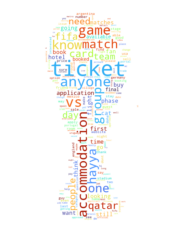

<Figure size 576x576 with 0 Axes>

In [171]:
# WordCloud of the most common words
text_combined = ' '.join(df_posts['text_clean'])

#Creating a mask
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "WorldCupTrophy.png")))

#WordCloud of all words
wc = WordCloud(width=3200, height=1600, max_font_size=200, mask = mask, background_color = 'white', colormap = 'turbo_r', collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.figure(figsize=(8,8), facecolor = 'k')
plt.show()


               count
keyword             
ticket           664
game             254
one              189
accommodation    179
qatar            151
match            145
anyone           140
people           133
team             127
need             125
day              124
group            123
fifa             115
hayya card       115
matches          104
going             97
think             96
time              96
want              90
know              89
looking           88
anyone know       86
hotel             86
still             86
go                84
see               79
available         76
flight            75
way               69
us                68


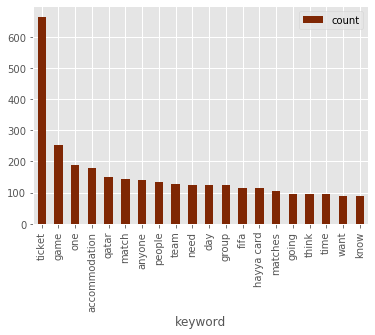

In [195]:
# Listing and counting the key words
kwords = WordCloud().process_text(text_combined)
kwords_df = pd.DataFrame(list(kwords.items()), 
                         columns = ['keyword', 'count']).set_index('keyword').sort_values(by = "count", 
                         ascending = False)

print(kwords_df.head(30))


# Top 20 words
%matplotlib inline
kwords_df.sort_values(by='count', ascending=False).head(20).plot.bar(colormap = 'Oranges_r')
plt.show()

In [175]:
# Finding Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

# Listing the Bigrams by frequency
bigram_freq = list(bigram_finder.ngram_fd.items())

# Transforming the list into a DataFrame
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)

# Top 20 Bigrams
df_freq.head(25)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


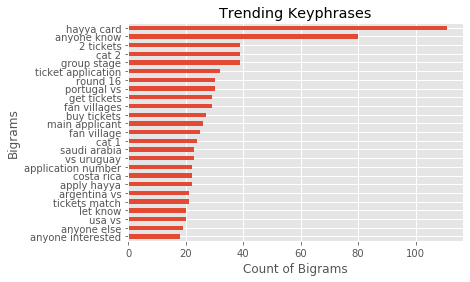

In [194]:
print(plt.style.available)

# Ploting Top 20 Bigrams
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(25).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending Keyphrases')
plt.ylabel('Bigrams')
plt.xlabel('Count of Bigrams')
plt.legend().set_visible(False)
plt.show()

# Report



- Pedro Henrique Schaidt Andrade 
- Social Media Analytics    
- Professors: Pavel Paramonov and Beau Giannini                                                                                  

The idea of this analysis was to get an idea of the trending topics regarding the World Cup in Qatar, which is happening this year in November/December. Using the concepts and technical skills we learned in class, through Python Programming Language and Analysis, I could access Reddit's API (Step 1) and collect data on the hottest posts on the 'worldculp' subreddit - https://www.reddit.com/r/worldcup/ (Step 2).

Setting some parameters like the number of posts, comments and subcomments, we collected the data and saved it in a json file, that was letter read using Python, so I could perform the analysis (Step 3). On this stage, I structured the data collected into a data frame using pandas and performed a text cleaning using a user defined function (text_clean). 

Analyzing then the new cleaned text after adding some other stop words to the list created, I could see that the most frequent used words and bigrams (keyphrases) were related to tickets, accommodations in Qatar (hotels, fan villages). Reddit is being used as a marketplace for tickets to the 2022 World Cup, where users are trying to find other users who are selling or buying game tickets for specific games of countries like Uruguay, Saudi Arabia, Argentina, Costa Rica, US. Interesting to notice is that most of those countries are not really traditional or top ranked teams (except Argentine or Uruguay) so through this we can make sense of the location of some users.

Another trending topic is the Hayya Card, which is the official Fan ID of the World Cup. Users are interested on getting more information on the application process, or even buying cards through Reddit. What is interesting to notice is that when analyzing the word Hayya by itself, it can mislead you into another insight. Hayya is the name of the World Cup theme song, so using the Bigram function was crucial to get a context of the word.

World Cup game tickets are hard to get, being the process very long and you must count with a little bit of luck, since it works in a lottery format. So, as conclusion of this analysis, the main takeaway is that if you are interested in going to the World Cup, Reddit and the subreddit 'worldcup' might be a good place to look for tickets, places to stay and other information related to the event. Also, if you are one of the lucky ones who were able to get the tickets but unfortunately can not go the event, Reddit is a good platform to find possible buyers and make extra money selling the tickets based on the high demand.

